Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


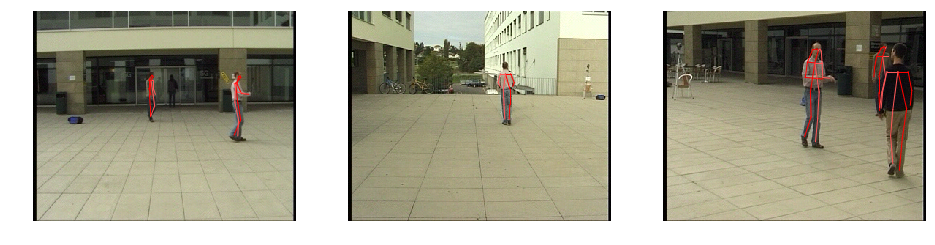

In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
sys.path.insert(0,'../debugging')
from mvpose.data import epfl_campus
from time import time

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d

from openpose import OpenPose

FRAME = 660
peak_threshold = 0.05  # 0.05
pe = OpenPose(tmp=tmp, peak_threshold=peak_threshold)
Im, Y, Calib = epfl_campus.get(root, FRAME)
predictions = pe.predict(Im, 'cvpr_campus' + str(peak_threshold), 
                         FRAME)


fig = plt.figure(figsize=(16, 8))
for idx, (im, pred) in enumerate(zip(Im, predictions)):
    ax = fig.add_subplot(1, 3, idx+1); ax.axis('off')
    ax.imshow(im)
    
    for human in pred:
        draw_mscoco_human2d(ax, human[:, 0:2], color='red')

plt.show()

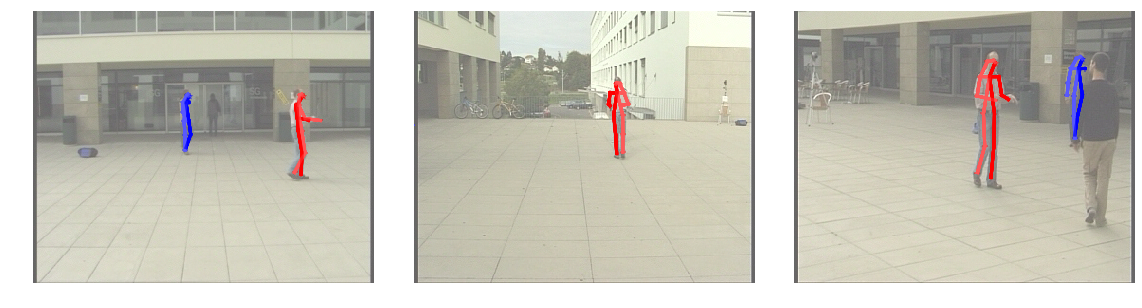

In [2]:
from mvpose.baseline.baseline import estimate

H = estimate(Calib, predictions, 
             epi_threshold=15,
             scale_to_mm=1000)

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green', 'teal']

for cid, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3, 1+cid)
    ax.axis('off')
    im = Im[cid]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(H):
        draw_mscoco_human(ax, hyp, cam, alpha=0.5,
                          color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [3]:
# track = tracks[6]

# gaps = []
# start_frame = track.first_frame()
# end_frame = track.last_seen()

# gap_active = False
# current_gap = None
# for frame in range(start_frame, end_frame):
#     pose = track.get_by_frame(frame)
#     if pose is None:
#         gap_active = True
#         if current_gap is None:
#             current_gap = [frame]
#         else:
#             current_gap.append(frame)
#     else:
#         if gap_active:
#             gaps.append(current_gap)
#         gap_active = False
#         current_gap = None
        
# gaps

In [4]:
valid_frames = list(range(350, 470)) + list(range(650, 750))

Calib = []
poses_per_frame = []
Pos3d = {}

_start = time()
for frame in valid_frames:
    if frame % 10 == 0:
        print('frame', frame)
    Im, Y, calib = epfl_campus.get(root, frame)
    Calib.append(calib)
    Pos3d[frame] = Y
    predictions = pe.predict(Im, 'cvpr_campus' + str(peak_threshold), 
                         frame)
    poses_per_frame.append(predictions)
_end = time()
print('elapsed', _end - _start)

frame 350
frame 360
frame 370
frame 380
frame 390
frame 400
frame 410
frame 420
frame 430
frame 440
frame 450
frame 460
frame 650
frame 660
frame 670
frame 680
frame 690
frame 700
frame 710
frame 720
frame 730
frame 740
elapsed 17.813665628433228


In [5]:
from mvpose.baseline.tracking import tracking, Track

_start = time()
tracks = tracking(Calib, poses_per_frame,
                  epi_threshold=10,
                  scale_to_mm=1000,
                  max_distance_between_tracks=200,
                  actual_frames=valid_frames,
                  min_track_length=4,
                  z_axis=2,
                  merge_distance=250,
                  last_seen_delay=5)
_end = time()
print('elapsed', _end - _start)

print("#tracks", len(tracks))

for track in tracks:
    print(len(track))
    
_start = time()
tracks_ = []
for track in tracks:
    track = Track.smoothing(track, 
                            sigma=4.2,
                            interpolation_range=50)
    tracks_.append(track)
tracks = tracks_
_end = time()
print("elapsed", _end - _start)

elapsed 2.0205960273742676
#tracks 11
102
75
16
4
100
17
13
10
73
4
68
n frames 102
n frames 75
n frames 16
n frames 4
n frames 100
n frames 17
n frames 13
n frames 10
n frames 73
n frames 4
n frames 68
elapsed 0.06449031829833984


In [6]:
# =====================================================
def proper_pcp_calc(Y, Humans):
    alpha = 0.5
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs

PER_GTID = {}
for frame in valid_frames:
    Humans = []
    for track in tracks:
        pose = track.get_by_frame(frame)
        if pose is not None:
            Humans.append(pose)
    Humans = kth.transform3d_from_mscoco(Humans)
    
    if frame % 12 == 0:
        print("Humans " + str(frame), len(Humans))
    
    Y = Pos3d[frame]
    L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = proper_pcp_calc(Y, Humans) 
    if len(L_Arms) > 0:
        for gtid, larms, uarms, llegs, ulegs in zip(
            GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
        ):
            if not gtid in PER_GTID:
                PER_GTID[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            PER_GTID[gtid]['larms'].append(larms)
            PER_GTID[gtid]['uarms'].append(uarms)
            PER_GTID[gtid]['llegs'].append(llegs)
            PER_GTID[gtid]['ulegs'].append(ulegs)
            PER_GTID[gtid]['frame'].append(frame)

Humans 360 1
Humans 372 1
Humans 384 1
Humans 396 2
Humans 408 2
Humans 420 2
Humans 432 2
Humans 444 2
Humans 456 2
Humans 468 2
Humans 660 3
Humans 672 2
Humans 684 3
Humans 696 3
Humans 708 3
Humans 720 3
Humans 732 3
Humans 744 3


In [7]:
total_avg = []
for key, values in PER_GTID.items():
    print('actor ', key)
    print('\tuarms:', np.mean(values['uarms']))
    print('\tlarms:', np.mean(values['larms']))
    print('\tulegs:', np.mean(values['ulegs']))
    print('\tllegs:', np.mean(values['llegs']))
    avg = np.mean([
        np.mean(values['uarms']),
        np.mean(values['larms']),
        np.mean(values['ulegs']),
        np.mean(values['llegs'])
    ])
    total_avg.append(avg)
    print('\tavg:  ', avg)
print('\navg*:  ', np.mean(total_avg))

actor  1
	uarms: 1.0
	larms: 0.6356382978723404
	ulegs: 1.0
	llegs: 1.0
	avg:   0.9089095744680851
actor  2
	uarms: 0.9669117647058824
	larms: 0.8088235294117647
	ulegs: 1.0
	llegs: 0.9926470588235294
	avg:   0.9420955882352942
actor  0
	uarms: 0.8645833333333334
	larms: 0.6145833333333334
	ulegs: 1.0
	llegs: 1.0
	avg:   0.8697916666666667

avg*:   0.906932276456682


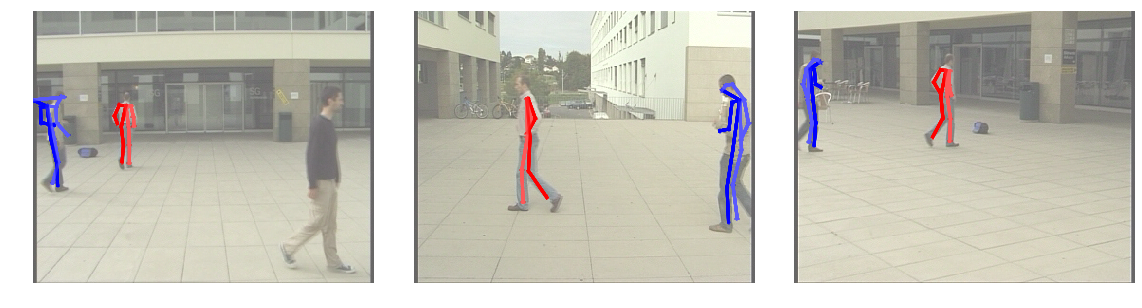

In [8]:
fig = plt.figure(figsize=(16,12))

FRAME = 401

H = []
Im, Y, Calib = epfl_campus.get(root, FRAME)
for track in tracks:
    pose = track.get_by_frame(FRAME)
    if pose is not None:
        H.append(pose)

colors = ['red', 'blue', 'green', 'teal']

for cid, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3, 1+cid)
    ax.axis('off')
    im = Im[cid]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(H):
        draw_mscoco_human(ax, hyp, cam, alpha=0.5, 
                            color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [9]:
# no smoothing
# ==== 0.1 ====
# actor  1
# 	uarms: 0.9920212765957447
# 	larms: 0.5558510638297872
# 	ulegs: 0.9946808510638298
# 	llegs: 0.9946808510638298
# 	avg:   0.8843085106382979
# actor  2
# 	uarms: 0.8272058823529411
# 	larms: 0.5992647058823529
# 	ulegs: 0.9926470588235294
# 	llegs: 0.9926470588235294
# 	avg:   0.8529411764705882
# actor  0
# 	uarms: 0.59375
# 	larms: 0.4479166666666667
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.7604166666666667

# avg*:   0.8325554512585175
# ==================

# ==== 0.06 ====
# actor  1
# 	uarms: 0.9893617021276596
# 	larms: 0.5478723404255319
# 	ulegs: 0.9893617021276596
# 	llegs: 0.9893617021276596
# 	avg:   0.8789893617021277
# actor  2
# 	uarms: 0.9411764705882353
# 	larms: 0.6286764705882353
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8924632352941176
# actor  0
# 	uarms: 0.7708333333333334
# 	larms: 0.46875
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8098958333333334

# avg*:   0.8604494767765263
# ==================

# ==== 0.05 ====
# actor  1
# 	uarms: 0.9840425531914894
# 	larms: 0.5425531914893617
# 	ulegs: 0.9840425531914894
# 	llegs: 0.9840425531914894
# 	avg:   0.8736702127659575
# actor  2
# 	uarms: 0.9411764705882353
# 	larms: 0.6617647058823529
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.9007352941176471
# actor  0
# 	uarms: 0.78125
# 	larms: 0.46875
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8125

# avg*:   0.8623018356278682
# ==================

In [10]:
# # =====================================
# def generate_pcp_score(frame):
#     global pe
#     alpha = 0.5
#     Im, Y, Calib = epfl_campus.get(root, frame)
#     predictions = pe.predict(Im, 'cvpr_campus', frame)
#     detections = estimate(Calib, predictions, epi_threshold=10)
#     Humans = kth.transform3d_from_mscoco(detections)
    
#     L_Arms = []
#     U_Arms = []
#     L_Legs = []
#     U_Legs = []
#     GTIDs = []
  
#     for gtid, gt in enumerate(Y):
#         if gt is None:
#             continue
        
#         larms = 0
#         uarms = 0
#         llegs = 0
#         ulegs = 0
#         avg = 0
#         for d in Humans:
#             r = pcp.evaluate(gt, d, alpha)
#             larms_ = r.lower_arms
#             uarms_ = r.upper_arms
#             ulegs_ = r.upper_legs
#             llegs_ = r.lower_legs
#             avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
#             if avg_ > avg:
#                 avg = avg_
#                 larms = larms_
#                 uarms = uarms_
#                 llegs = llegs_
#                 ulegs = ulegs_
        
#         L_Arms.append(larms)
#         U_Arms.append(uarms)
#         L_Legs.append(llegs)
#         U_Legs.append(ulegs)
#         GTIDs.append(gtid)
    
#     return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs

# # =====================================

# valid_frames = list(range(350, 470)) + list(range(650, 750))
# PER_GTID = {}

# for frame in valid_frames:
#     _start = time()
#     L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = generate_pcp_score(frame)
#     _end = time()
#     print('frame ' + str(frame) + ', elapsed:', _end - _start)
    
#     if len(L_Arms) > 0:
#         for gtid, larms, uarms, llegs, ulegs in zip(
#             GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
#         ):
#             if not gtid in PER_GTID:
#                 PER_GTID[gtid] = {
#                     'larms': [],
#                     'uarms': [],
#                     'llegs': [],
#                     'ulegs': [],
#                     'frame': []
#                 }
#             PER_GTID[gtid]['larms'].append(larms)
#             PER_GTID[gtid]['uarms'].append(uarms)
#             PER_GTID[gtid]['llegs'].append(llegs)
#             PER_GTID[gtid]['ulegs'].append(ulegs)
#             PER_GTID[gtid]['frame'].append(frame)
    

In [11]:
# total_avg = []
# for key, values in PER_GTID.items():
#     print('actor ', key)
#     print('\tuarms:', np.mean(values['uarms']))
#     print('\tlarms:', np.mean(values['larms']))
#     print('\tulegs:', np.mean(values['ulegs']))
#     print('\tllegs:', np.mean(values['llegs']))
#     avg = np.mean([
#         np.mean(values['uarms']),
#         np.mean(values['larms']),
#         np.mean(values['ulegs']),
#         np.mean(values['llegs'])
#     ])
#     total_avg.append(avg)
#     print('\tavg:  ', avg)
# print('\navg*:  ', np.mean(total_avg))